# Evaluation

## Preparation
### Imports

In [1]:
import pickle # loading the results dictionary
import pandas as pd, polars as pl # dataframes
import matplotlib.pyplot as plt # plotting

# metrics and visualization
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, fbeta_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.metrics import specificity_score


### Warnings

In [ ]:
import warnings
# possibly given if bootstrap scores are zero
warnings.filterwarnings("ignore", category=UserWarning)

### Loading the Data

In [ ]:
with open ('./results.pkl', 'rb') as file:
    results = pickle.load(file)

### Definitions

In [2]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'f2': fbeta_score,
    'specificity': specificity_score,

}

estimators = [
    'logistic_regression',
    'random_forest',
    'support_vector_machine',
    'naive_bayes',
    'llama'
]

### Helper Functions

In [3]:
def plot_confusion_matrix(matrix, ax):
    disp = ConfusionMatrixDisplay(matrix, display_labels=['Exclude', 'Include'])
    disp.plot(ax=ax, colorbar=False)

In [ ]:
def plot_confusion_matrices(dataset):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Decrease figure size
    axes = axes.flatten()

    for i, estimator in enumerate(estimators):
        matrix = results['datasets'][dataset][estimator]['matrix']['norm']
        plot_confusion_matrix(matrix, axes[i])

    for i in range(len(estimators), len(axes)):
        fig.delaxes(axes[i])
    
    # Ensure that at least one axis contains an image before adding a colorbar
    if any(ax.images for ax in axes):
        # Add a single colorbar for all subplots
        cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust color bar size and position
        for ax in axes:
            if ax.images:
                fig.colorbar(ax.images[0], cax=cbar_ax)
                break

    fig.suptitle(dataset, fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

In [4]:
def print_summary(dataset):
    summary = results['scores'].filter(
        pl.col('dataset') == dataset
    ).select(pl.exclude('dataset'))
    with pl.Config(tbl_cols=-1, tbl_width_chars=1000):
        print(summary, end='\n\n')

## Inspection
### Confusion Matrices

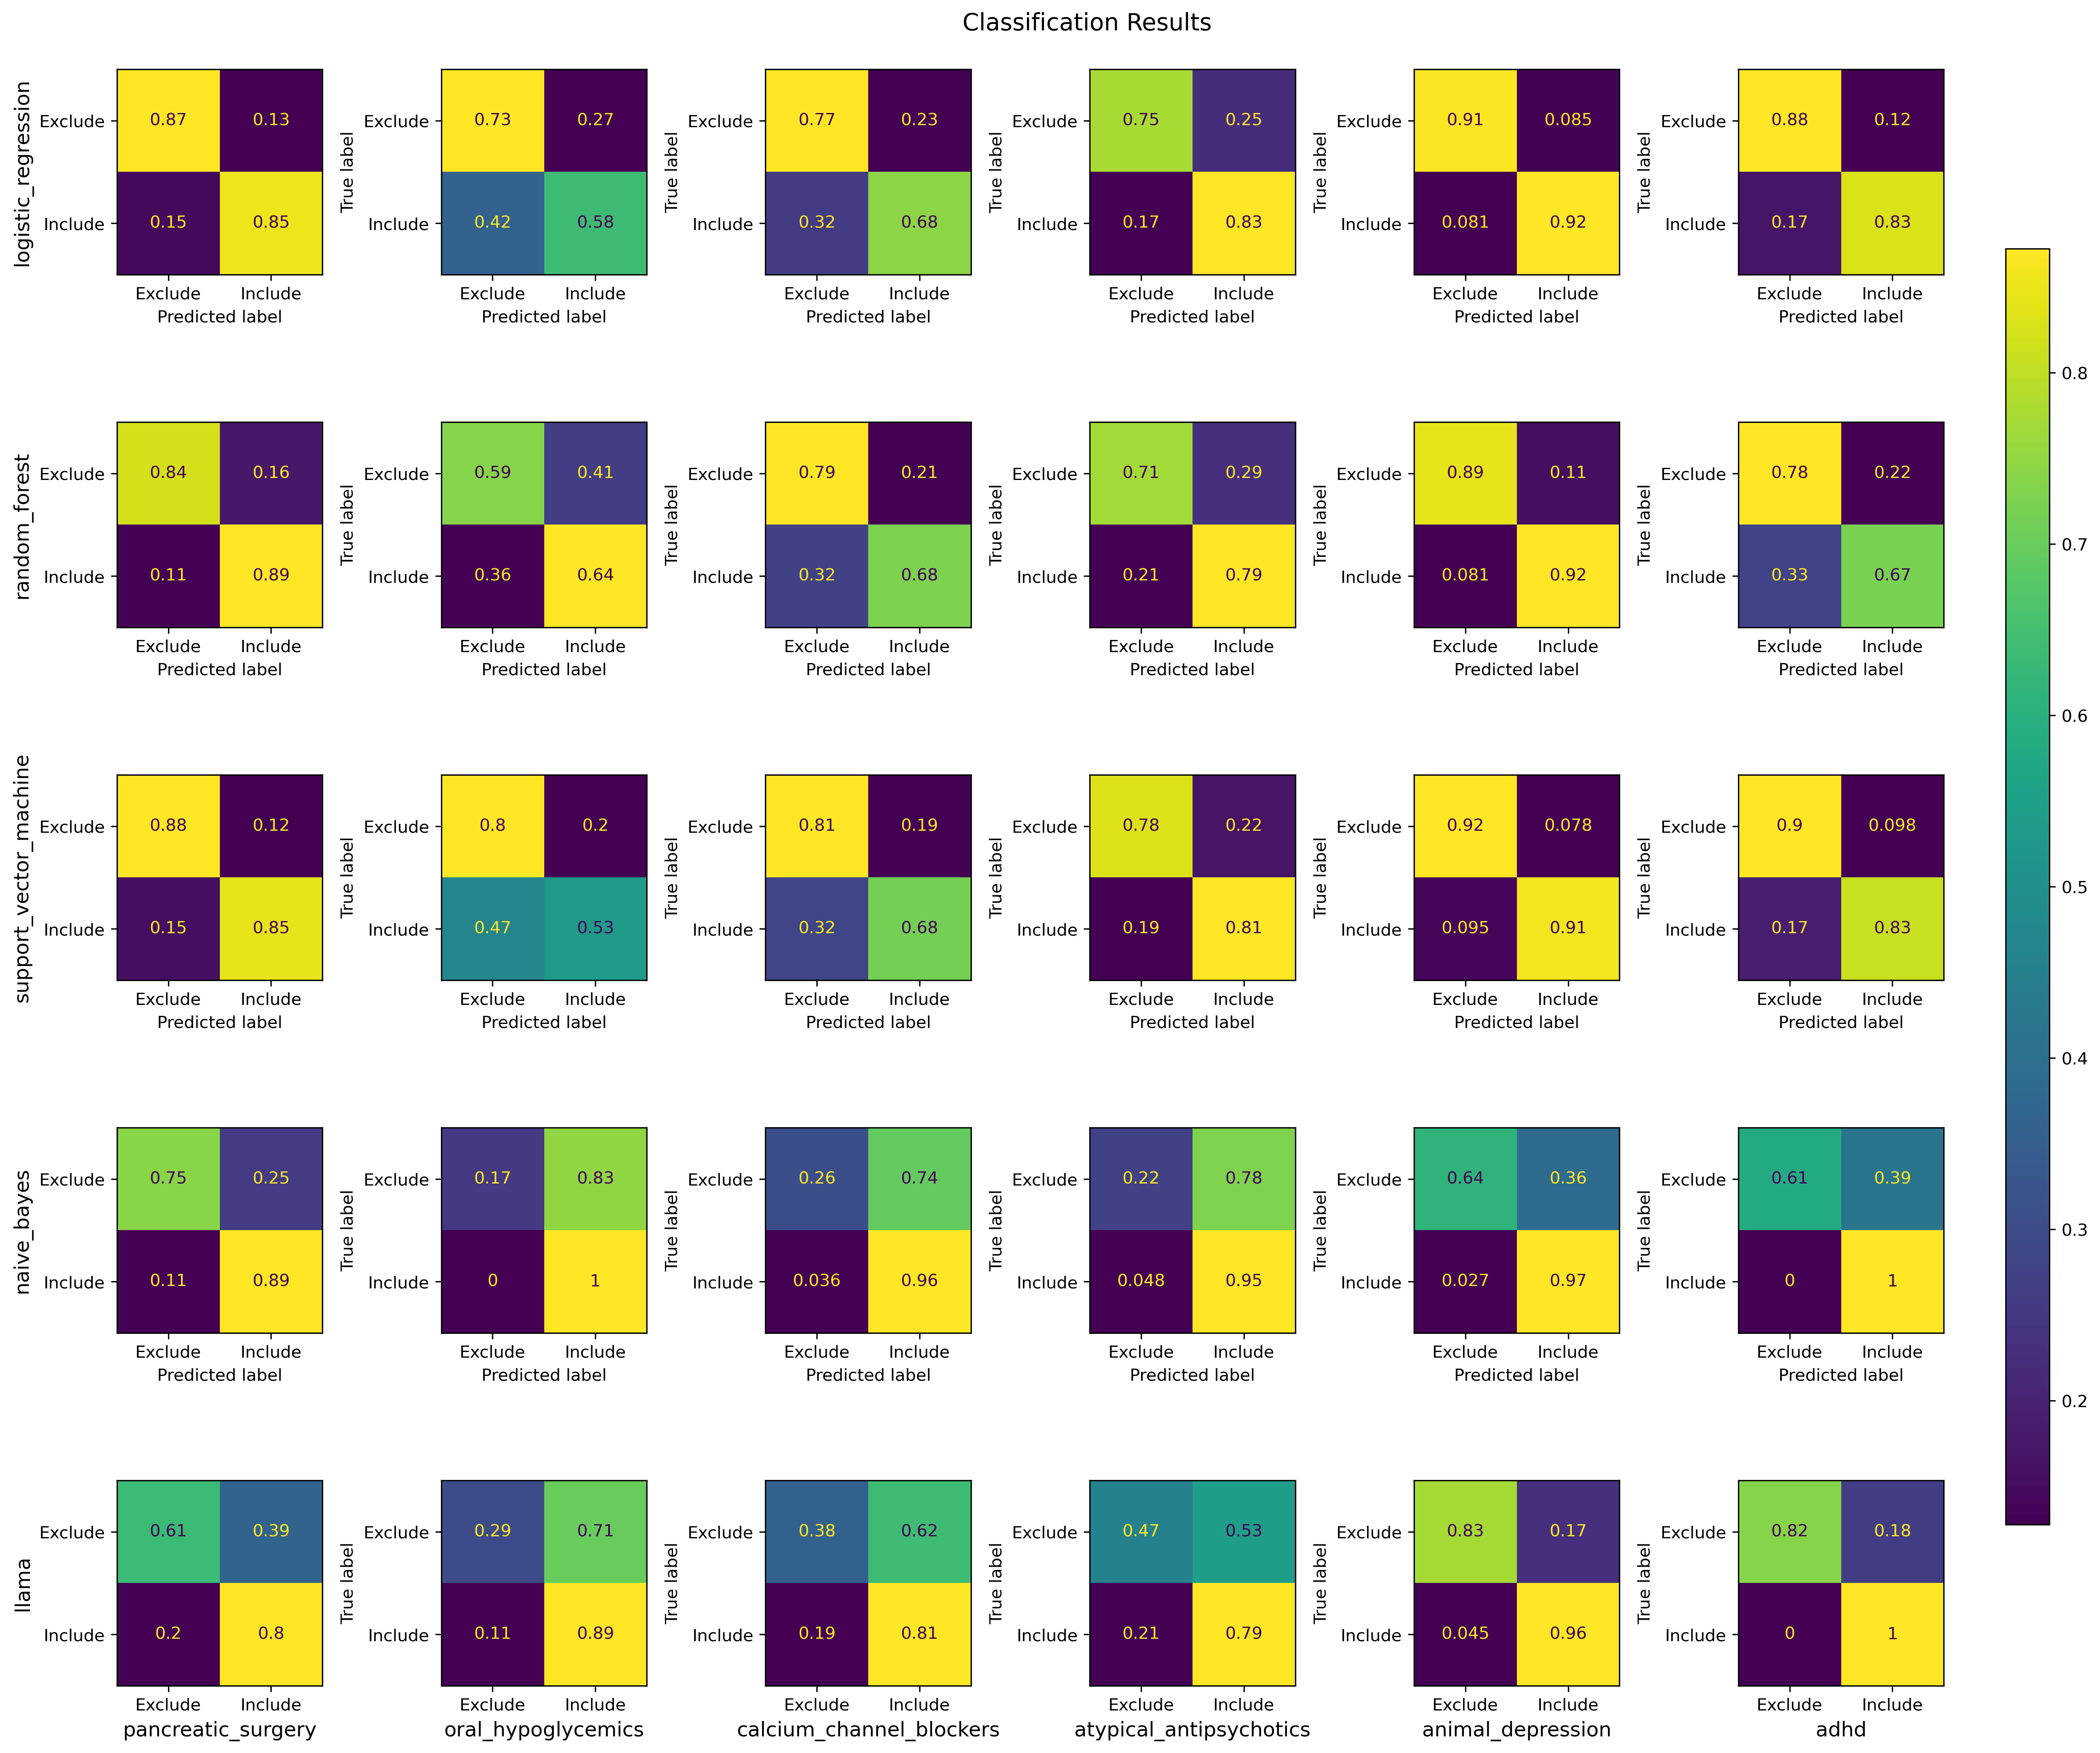

In [14]:
# Get the list of datasets and estimators
datasets = list(results['datasets'].keys())
datasets.reverse()

estimators = list(results['datasets'][datasets[0]].keys())

# Create a figure with subplots for each dataset and estimator
fig, axes = plt.subplots(len(estimators), len(datasets), figsize=(18, 15), dpi=300)  # Adjust the figure size as needed

# Iterate over each dataset and estimator to plot the confusion matrices
for i, estimator in enumerate(estimators):
    for j, dataset in enumerate(datasets):
        ax = axes[i, j]
        matrix_norm = results['datasets'][dataset][estimator]['matrix']['norm']
        plot_confusion_matrix(matrix_norm, ax)

# Set the y-axis labels to the estimators
for i, estimator in enumerate(estimators):
    axes[i, 0].set_ylabel(estimator, fontsize=12)

# Set the x-axis labels to the datasets below the lowest subplot in each column
for j, dataset in enumerate(datasets):
    axes[-1, j].set_xlabel(dataset, fontsize=12)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(axes[0, 0].images[0], cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 0.98])
plt.suptitle('Classification Results', fontsize=14)

# Save the figure as an SVG file
plt.savefig('confusion_matrices.svg', format='svg')
plt.show()

## Metric Boxplots
### Score DataFrame
To efficiently plot the bootstrapped metric scores, store all scores within one big dataframe:

In [6]:
# Create a list to collect data
data = []

for dataset in results['datasets']:
    for estimator in results['datasets'][dataset]:
        for metric in results['datasets'][dataset][estimator]['bootstrap']['scores']:
            scores = results['datasets'][dataset][estimator]['bootstrap']['scores'][metric]

            for score in scores:
                data.append({'dataset': dataset, 'estimator': estimator, 'metric': metric, 'score': score})




# Create a DataFrame from the collected data
df = pl.DataFrame(data)

### Plot Metrics

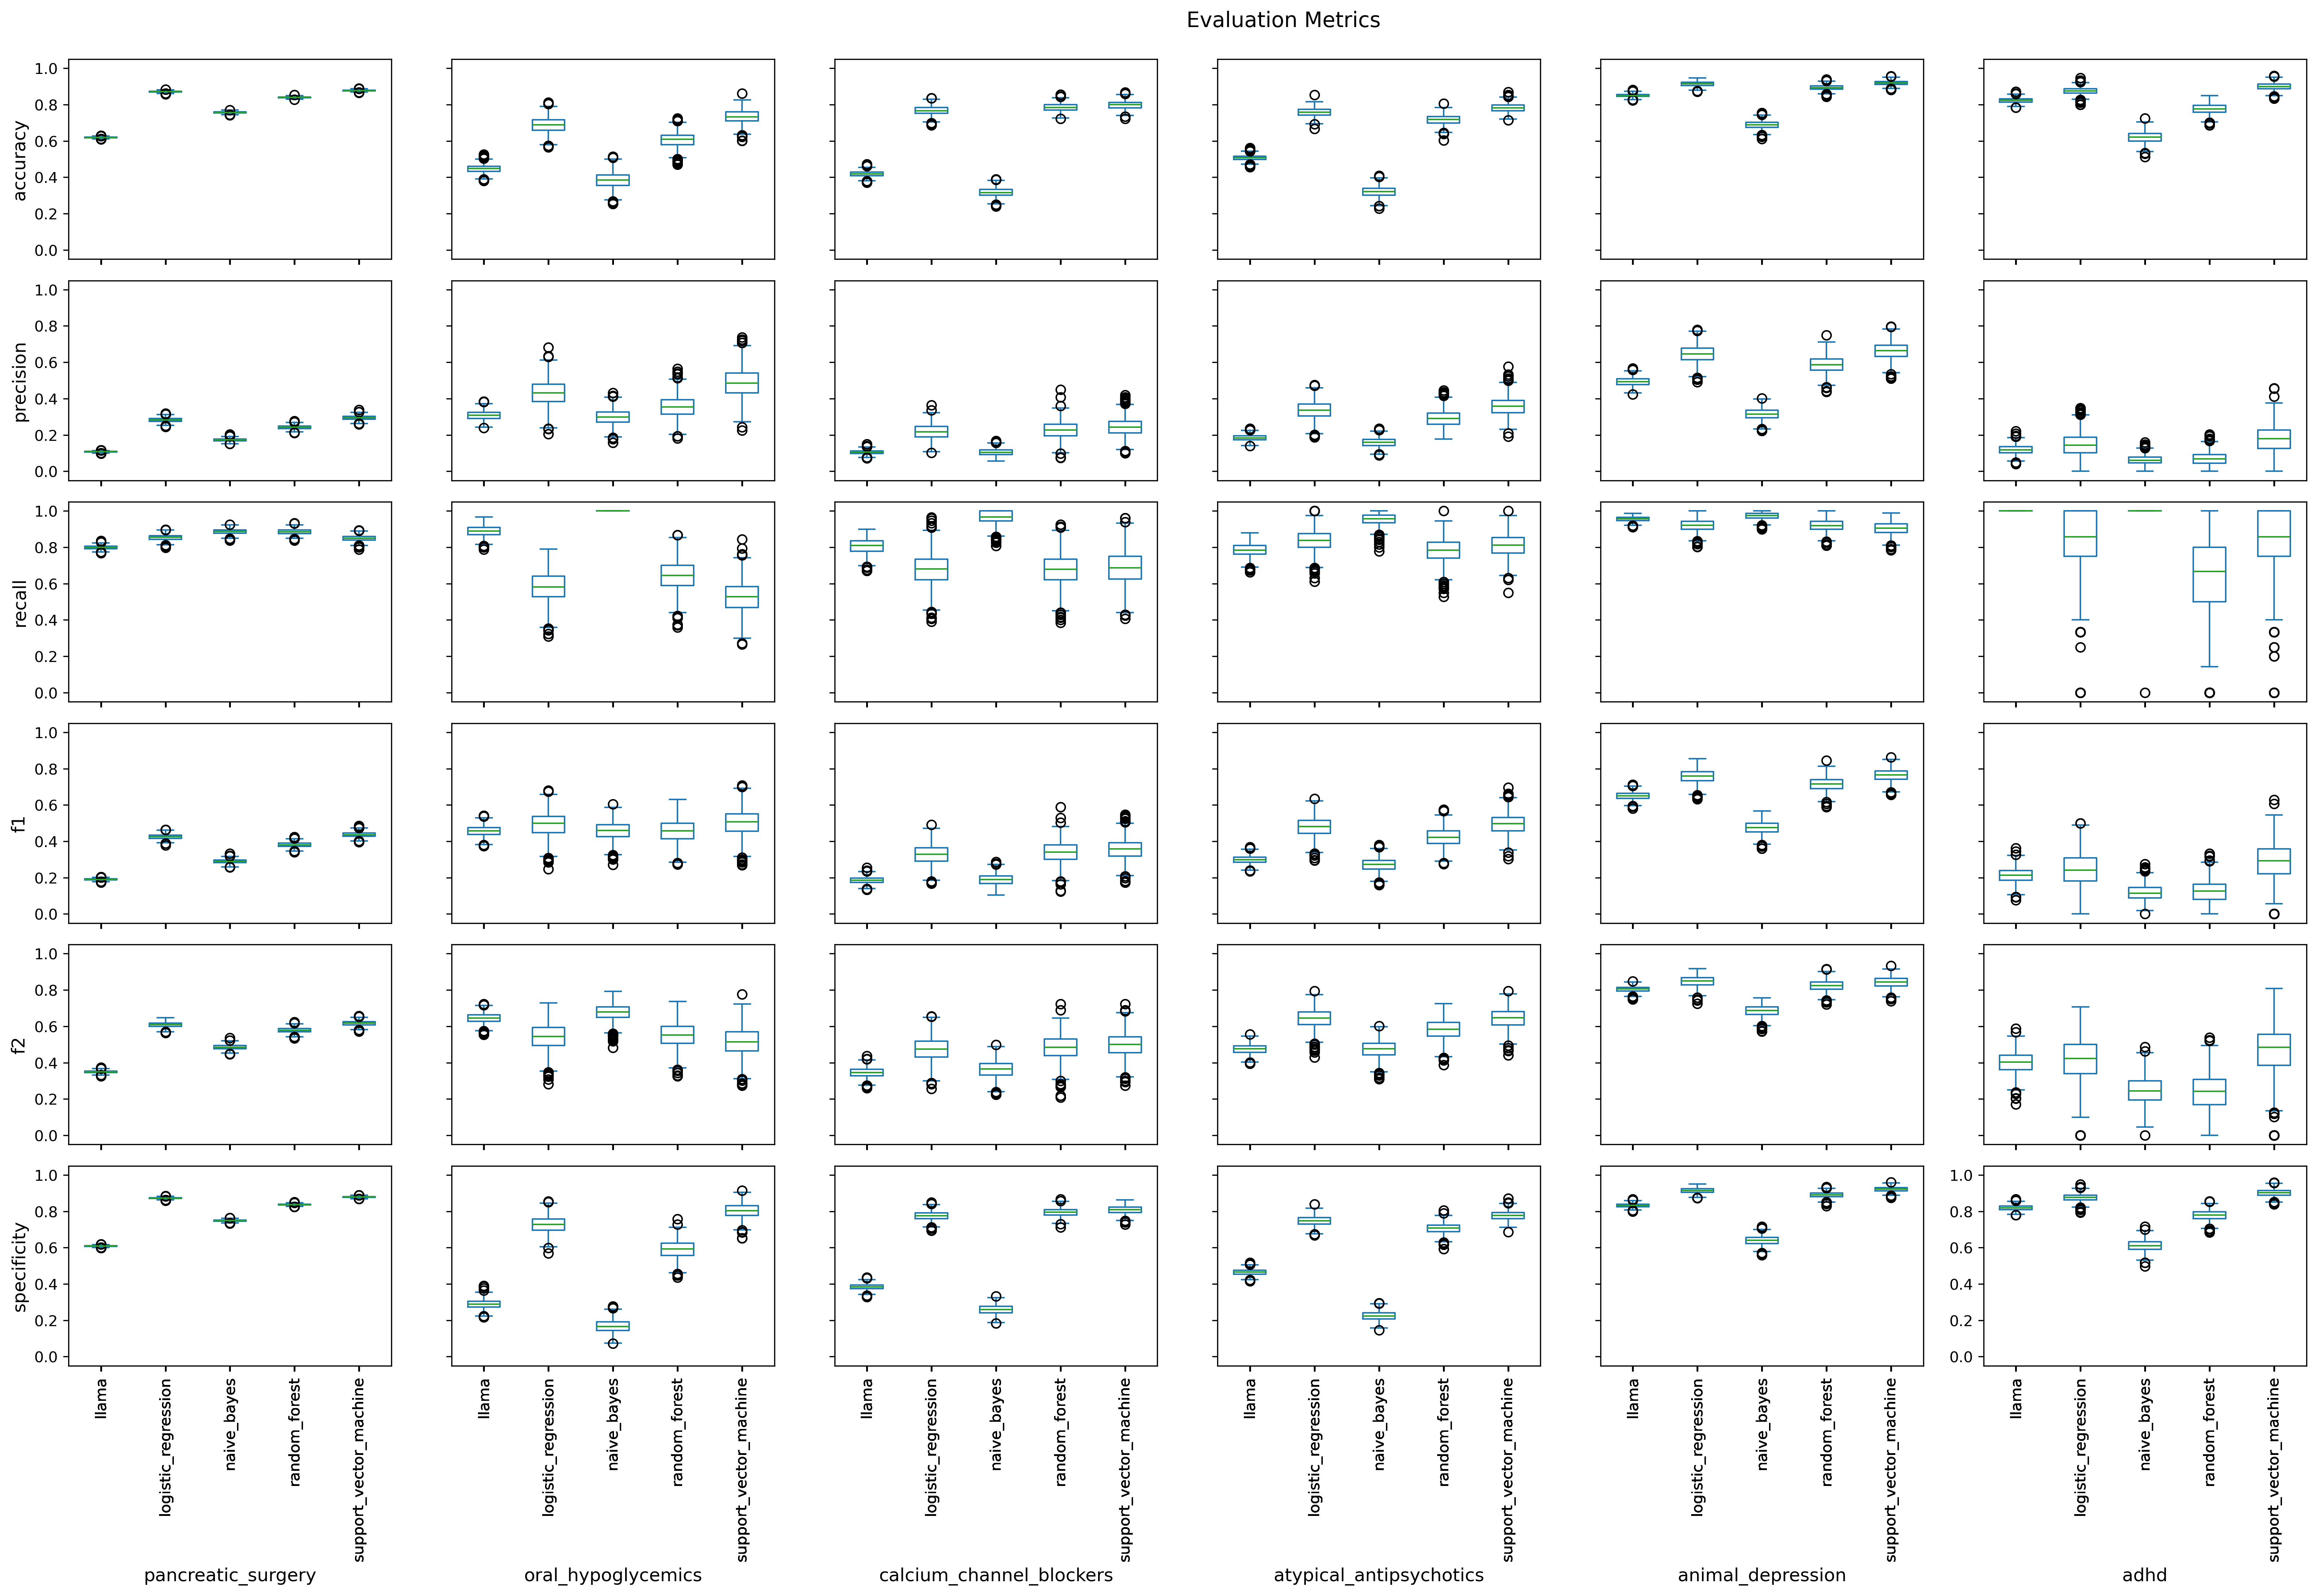

In [15]:
# Reorder the datasets to have "pancreatic surgery" first
list_datasets = list(results['datasets'].keys())
list_datasets.reverse()

list_metrics = list(metrics.keys())

# Increase the width of the figure
fig, axes = plt.subplots(len(list_metrics), len(list_datasets), figsize=(24, 15), sharex=True, sharey=True, dpi=300)

for i, metric in enumerate(list_metrics):
    for j, dataset in enumerate(list_datasets):
        ax = axes[i, j]
        
        df.filter(
            pl.col('dataset') == dataset
        ).filter(
            pl.col('metric') == metric
        ).to_pandas().plot(kind='box', by='estimator', ax=ax)
        
        # Remove the title of the subplot
        ax.set_title('')
        
        # Set the y-axis labels to the metrics for the first column
        if j == 0:
            ax.set_ylabel(metric, fontsize=12)
        
        # Set the x-axis labels to the datasets below the lowest subplot in each column
        if i == len(list_metrics) - 1:
            ax.set_xlabel(dataset, fontsize=12)
        
        # Rotate the x-ticks by 90 degrees
        ax.tick_params(axis='x', rotation=90)
        
        # Ensure y-ticks are shown for each subplot
        ax.yaxis.set_tick_params(which='both', labelleft=True)

plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.suptitle('Evaluation Metrics', fontsize=14)

# Save the figure as an SVG file
plt.savefig('evaluation_metrics.svg', format='svg')

plt.show()

## Metric Summary
Print metrics for each dataset and estimator:

In [13]:
for dataset in results['datasets']:
    print(dataset)
    print_summary(dataset)

adhd
shape: (5, 7)
┌────────────────────────┬──────────────────┬──────────────────┬─────────────────┬──────────────────┬──────────────────┬──────────────────┐
│ estimator              ┆ accuracy         ┆ precision        ┆ recall          ┆ f1               ┆ f2               ┆ specificity      │
│ ---                    ┆ ---              ┆ ---              ┆ ---             ┆ ---              ┆ ---              ┆ ---              │
│ str                    ┆ struct[3]        ┆ struct[3]        ┆ struct[3]       ┆ struct[3]        ┆ struct[3]        ┆ struct[3]        │
╞════════════════════════╪══════════════════╪══════════════════╪═════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ logistic_regression    ┆ {0.87,0.83,0.92} ┆ {0.15,0.03,0.28} ┆ {0.83,0.5,1.0}  ┆ {0.24,0.06,0.43} ┆ {0.41,0.13,0.64} ┆ {0.88,0.83,0.92} │
│ random_forest          ┆ {0.78,0.72,0.82} ┆ {0.07,0.02,0.15} ┆ {0.66,0.2,1.0}  ┆ {0.13,0.03,0.25} ┆ {0.24,0.06,0.43} ┆ {0.78,0.73,0.83} │
│